# Single zone (France) with electricity storage...
In this case, several electricity production units exist (CGC, GT, nuclear, on-shore wind or solar PV) and produce electricity that can be stored in batteries to satisfy the demand. 

## Setup 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pyomo.environ as pyo
import time 
import Functions.f_multiResourceModels as fMultiResModels
import Functions.f_optimization as fOptimization 


nHours = 8760
t = np.arange(1,nHours + 1)

## Input data 

We define some basic parameters of the case, such as the node names (zones), the year and the conversion technologies used. 

In [2]:
zones=["PACA"] 
year=2013
ctechs=['OldNuke','WindOnShore', 'Solar','CCG','TAC']
stechs = ['Battery', 'tankH2_G']

### Demand for resources
The demand for resources is given for each hour of the year in MW, in the format of a `DataFrame`. For fuels, the MW value corresponds to the lower heating value (LHV). The values for each resource are given in the form of an array with `nHours` elements, which could be for instance read from a CSV file.

In [3]:
df_resource_demand =  pd.DataFrame(data = { 
              'TIMESTAMP': t, # We add the TIMESTAMP so that it can be used as an index later. 
              'electricity': pd.read_csv('Data/Raw/electricity-demand-France-2013.csv', sep=',', decimal='.', index_col=0,header=0).values.flatten(),
              'hydrogen': np.zeros(nHours), 
              'gas': np.zeros(nHours), 
              'uranium': np.zeros(nHours)
             } 
)
df_resource_demand

,TIMESTAMP,electricity,hydrogen,gas,uranium
0,1,57820,0.0,0.0,0.0
1,2,57183,0.0,0.0,0.0
2,3,54320,0.0,0.0,0.0
3,4,50742,0.0,0.0,0.0
4,5,48982,0.0,0.0,0.0
...,...,...,...,...,...
8755,8756,62012,0.0,0.0,0.0
8756,8757,59976,0.0,0.0,0.0
8757,8758,64280,0.0,0.0,0.0
8758,8759,64702,0.0,0.0,0.0


We can access the demand profiles like this: 

<AxesSubplot:xlabel='Time (h)', ylabel='Resource demand (MW)'>

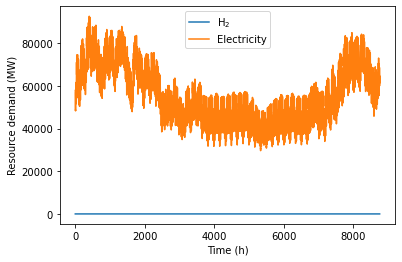

In [4]:
df_resource_demand.plot(x='TIMESTAMP', y=['hydrogen','electricity'], xlabel='Time (h)', 
                        ylabel='Resource demand (MW)', label=['H$_2$', 'Electricity'])

### Availability factors
The availability factors correspond to the share of a conversion technology capacity that is available during a given hour. In this case it is read from raw hourly data obtained elsewhere. 

In [5]:
availabilityFactor = pd.read_csv('Data/Input/availabilityFactor' + str(year) + '_' + str(zones[0]) + '_TIMExTECH.csv',
                                 sep=',', decimal='.', skiprows=0).set_index(["TIMESTAMP", "TECHNOLOGIES"])
itechs = availabilityFactor.index.isin(ctechs, level=1)
availabilityFactor = availabilityFactor.loc[(slice(None), itechs),:]

### Conversion technology parameters 
These are the techno-economic parameters of each conversion technology. The following parameters are given: 

| Parameter       | Unit          | Description |
| :-------------  | :-----------: | :-----------|
| `powerCost`     | EUR/MW        | Power-dependant component of the operating expenses (OPEX) |
| `capacityCost`  | EUR/MW        | Capital expenditure (CAPEX) on a capacity basis |
| `minCapacity`  | MW        | Minimal allowed capacity |
| `maxCapacity`  | MW        | Maximal allowed capacity |
| `RampConstraintPlus`  | % of capacity/h        | Maximal allowed positive ramp |
| `RampConstraintMoins`  | % of capacity/h        | Maximal allowed negative ramp |
| `EmissionCO2`  | tCO$_2$/MW      | Power-dependant greenhouse gas emissions (GHG) |
| `Conversion`  | MW      | Amount of resource produced or consumed (negative) for an operating power of 1 MW |

In [6]:
df_ctech_params = pd.DataFrame(data={
        'OldNuke': {
            'powerCost': 0, 
            'capacityCost': 245060, 
            'minCapacity': 0.001, 
            'maxCapacity': 0.001, 
            'RampConstraintPlus': 0.04, # Ramp rates as percent of maximal capacity per hour
            'RampConstraintMoins': 0.04, 
            'EmissionCO2': 0,
            'Conversion': {'electricity': 1, 'uranium':-3.03},
            },                                     
        'SMR_class': {
            'powerCost': 0, 
            'capacityCost': 62563, 
            'minCapacity': 0, 
            'maxCapacity': 1e6,
            'EmissionCO2': 354,
            'Conversion': {'hydrogen': 1, 'gas':-1.53},
            }, 
        'TAC': {
            'powerCost': 0, 
            'capacityCost': 86830, 
            'minCapacity': 0, 
            'maxCapacity': 0,
            'EmissionCO2': 6000,
            'Conversion': {'electricity': 1, 'gas':-2.70},
            },     
        'Coal_p': {
            'powerCost': 0, 
            'capacityCost': 10350, 
            'minCapacity': 0, 
            'maxCapacity': 0,
            'RampConstraintPlus': 0.06, 
            'RampConstraintMoins': 0.06, 
            'EmissionCO2': 10000,
            'Conversion': {'electricity': 1, 'uranium':-2.70},
            }, 
        'CCG': {
            'powerCost': 0, 
            'capacityCost': 96830, 
            'minCapacity': 0, 
            'maxCapacity': 1000,
            'RampConstraintPlus': 0.06, 
            'RampConstraintMoins': 0.06, 
            'EmissionCO2': 4700,
            'Conversion': {'electricity': 1, 'gas':-1.72},
            }, 
        'WindOnShore': {
            'powerCost': 0, 
            'capacityCost': 103750, 
            'minCapacity': 0, 
            'maxCapacity': 100000, 
            'EmissionCO2': 0,
            'Conversion': {'electricity': 1},
            },     
        'Solar': {
            'powerCost': 0, 
            'capacityCost': 63250, 
            'minCapacity': 0, 
            'maxCapacity': 100000, 
            'EmissionCO2': 0,
            'Conversion': {'electricity': 1},
            },     
        'HydroReservoir': {
            'powerCost': 0, 
            'capacityCost': 39180, 
            'minCapacity': 0, 
            'maxCapacity': 2100, 
            'EmissionCO2': 0,
            'Conversion': {'electricity': 1},
            }, 
})



### Discount and finance rate
Some general economic parameters.  

In [7]:
df_economic_params = pd.DataFrame({
    'discountRate':[0.04], 
    'financeRate': [0.04]
    }
)

###  Resource import price
These are the prices of imported resources, which should be given as in the form of an array with `nHours` elements, which could be for instance read from a CSV file. Values are given in EUR/MWh. 

In [8]:
df_resource_import_prices = pd.DataFrame(data={
    'TIMESTAMP': t, 
    'electricity': 250 * np.ones(nHours),
    'gas': 40 * np.ones(nHours),
    'uranium': 2.2 * np.ones(nHours),
    'hydrogen': 1e6 * np.ones(nHours),
})

### Storage parameters

These are the techno-economic parameters of each storage technology. The following parameters are given: 

| Parameter       | Unit          | Description |
| :-------------  | :-----------: | :-----------|
| `resource `     |               | The stored resource |
| `storagePowerCost` | EUR/MW        | Power-dependant component of the capital expenditure (CAPEX) |
| `storageEnergyCost`  | EUR/MWh       | Energy-dependant component of the capital expenditure (CAPEX) |
| `p_max`  | MW        | Maximal allowed power |
| `c_max`  | MWh       | Maximal allowed capacity |
| `dissipation`  | % of charge lost/h        | Maximal allowed positive ramp |



In [9]:
df_stech_params = pd.DataFrame(data={
                'Battery':  {
                            'resource': 'electricity', 
                            'storagePowerCost': 10753, 
                            'storageEnergyCost': 15658, 
                            'p_max': 5000, 
                            'c_max': 50000, 
                            'chargeFactors': {'electricity': 0.9200},
                            'dischargeFactors': {'electricity': 1.09},
                            'dissipation': 0.0085,
                            }, 
                'tankH2_G': {
                            'resource': 'hydrogen', 
                            'storagePowerCost': 1121, 
                            'storageEnergyCost': 604, 
                            'p_max': 0, 
                            'c_max': 0, 
                            'chargeFactors': {'electricity': 0.0168, 'hydrogen': 1.0},
                            'dischargeFactors': {'hydrogen': 1.0},
                            'dissipation': 0,
                            }, 
               })
    

df_stech_params 

,Battery,tankH2_G
resource,electricity,hydrogen
storagePowerCost,10753,1121
storageEnergyCost,15658,604
p_max,5000,0
c_max,50000,0
chargeFactors,{'electricity': 0.92},"{'electricity': 0.0168, 'hydrogen': 1.0}"
dischargeFactors,{'electricity': 1.09},{'hydrogen': 1.0}
dissipation,0.0085,0


### Grid connection parameters
These are parameters related to the French TURPE representing the grid connection costs. 

In [10]:
df_grid_cnx_params = pd.read_csv('Data\Raw\CalendrierHPHC_TIME.csv', sep=',', decimal='.', skiprows=0,
                                comment="#").set_index(["TIMESTAMP"])

## Running the model
We start by converting our dataframes to the formats required by the optimisation model. 

In [11]:
areaConsumption = df_resource_demand.melt(id_vars=['TIMESTAMP'], var_name='RESOURCES', value_name='areaConsumption').set_index(['TIMESTAMP', 'RESOURCES'])

TechParameters = df_ctech_params.transpose().fillna(0)
TechParameters.index.name='TECHNOLOGIES'
TechParametersList = ['powerCost','capacityCost','EnergyNbhourCap','minCapacity','maxCapacity','RampConstraintPlus','RampConstraintMoins','RampConstraintPlus2','RampConstraintMoins2','EmissionCO2']
for k in TechParametersList:
    if k not in TechParameters:
        TechParameters[k] = 0 
TechParameters.drop(columns='Conversion', inplace=True)
TechParameters

conversionFactor = pd.DataFrame(data={tech: df_ctech_params.loc['Conversion',tech] for tech in df_ctech_params.columns}).fillna(0)
conversionFactor.index.name='RESOURCES'
conversionFactor = conversionFactor.reset_index('RESOURCES').melt(id_vars=['RESOURCES'], var_name='TECHNOLOGIES',value_name='conversionFactor').set_index(['RESOURCES', 'TECHNOLOGIES'])

ImportPrices = df_resource_import_prices.melt(id_vars=['TIMESTAMP'], var_name='RESOURCES', value_name='importCost').set_index(['TIMESTAMP', 'RESOURCES'])

Economics = df_economic_params.melt(var_name='Eco').set_index('Eco')


StorageParameters = df_stech_params.transpose().fillna(0)
StorageParameters.index.name='STOCK_TECHNO'
StorageParametersList = ['resource', 'storagePowerCost', 'storageEnergyCost', 'p_max', 'c_max']
for k in StorageParametersList:
    if k not in StorageParameters:
        StorageParameters[k] = 0 
StorageParameters.drop(columns=['chargeFactors', 'dischargeFactors', 'dissipation'], inplace=True)
StorageParameters

df = {}
for k1, k2 in (('charge', 'In'),  ('discharge', 'Out')): 
    df[k1] = pd.DataFrame(data={tech: df_stech_params.loc[k1 + 'Factors',tech] for tech in df_stech_params.columns}).fillna(0)
    df[k1].index.name='RESOURCES'
    df[k1] = df[k1].reset_index(['RESOURCES']).melt(id_vars=['RESOURCES'], var_name='TECHNOLOGIES',value_name='storageFactor' + k2)

df['dissipation'] = pd.concat(pd.DataFrame(
                                  data={'dissipation': [df_stech_params.loc['dissipation',tech]], 
                                        'RESOURCES': df_stech_params.loc['resource',tech], 
                                        'TECHNOLOGIES': tech}) for tech in df_stech_params.columns
                             )

storageFactors = pd.merge(df['charge'], df['discharge'], how='outer').fillna(0)
storageFactors = pd.merge(storageFactors, df['dissipation'], how='outer').fillna(0).set_index(['RESOURCES', 'TECHNOLOGIES'])

Calendrier = df_grid_cnx_params

We run the model (this may take sometime, around 3-4 min with glpk, 40 s with mosek)...

In [12]:
startTime = time.time()
model= fMultiResModels.GetElectricSystemModel_MultiResources_SingleNode_WithStorage(
    areaConsumption, 
    availabilityFactor, 
    TechParameters,
    ImportPrices,
    conversionFactor,
    StorageParameters,
    storageFactors
)
opt = pyo.SolverFactory('mosek', executable=r'C:\Users\p.affonso_nobrega\Anaconda3\pkgs\glpk-5.0-h8ffe710_0\Library\bin\glpsol.exe')
results = opt.solve(model)
compTime = time.time() - startTime 

print('Computational time : {:.0f} s'.format(compTime))

Computational time : 39 s


And we retrieve the result variables in `DataFrame` format.

| Parameter       | Unit          | Description |
| :-------------  | :-----------: | :-----------|
| `power_Dvar`     | MW      | Power of each conversion technology at each time step.|
| `powerCosts_Pvar`     | EUR    | Sum of power-dependant costs for each conversion technology.|
| `capacityCosts_Pvar`     | EUR    | Sum of capacity-dependant costs for each conversion technology.|
| `capacity_Dvar`     | EUR    | Capacity for each conversion technology.|
| `importation_Dvar`  | MW        | Amount of each resource imported at each time step. |
| `importCosts_Pvar`  | EUR        | Sum of import costs for each resource. |
| `energy_Pvar`  | MW        | Produced power for each resource at each time step. |
| `carbon_Pvar`  | tCO$_2$/h      | Greenhouse gas emissions (GHG) at each time step.|
| `storageIn_Pvar`  |   MW   | Power charge in each storage technology at each time step for each resource.|
| `storageOut_Pvar`  |    MW  | Power discharge from each storage technology at each time step for each resource.|
| `storageConsumption_Pvar`  |    MW  | Additional power consumed by each storage technology at each time step for each resource.|
| `storageCosts_Pvar`     | EUR    | Sum of energy and power-dependant costs for each storage technology.|
| `Cmax_Dvar`     | MWh    | Storage technology energy capacity.|
| `stockLevel_Pvar`     | MWh    | Storage technology state of charge.|
| `Pmax_Dvar`     | MW    | Storage technology power capacity.|

In [13]:
outputData = fOptimization.getVariables_panda_indexed(model)
for v in outputData.values():
    display(v)

,TIMESTAMP,TECHNOLOGIES,power_Dvar
0,1,CCG,1000.000000
1,1,Solar,0.000000
2,1,WindOnShore,58393.408814
3,1,TAC,0.000000
4,1,OldNuke,0.000909
...,...,...,...
70075,8760,TAC,0.000000
70076,8760,OldNuke,0.000867
70077,8760,HydroReservoir,2100.000000
70078,8760,Coal_p,0.000000


,TECHNOLOGIES,powerCosts_Pvar
0,CCG,0.0
1,Solar,0.0
2,WindOnShore,0.0
3,TAC,0.0
4,OldNuke,0.0
5,HydroReservoir,0.0
6,Coal_p,0.0
7,SMR_class,0.0


,TIMESTAMP,RESOURCES,importation_Dvar
0,1,electricity,-0.000000
1,1,hydrogen,-0.000000
2,1,gas,1720.000000
3,1,uranium,0.002755
4,2,electricity,-0.000000
...,...,...,...
35035,8759,uranium,0.002632
35036,8760,electricity,12393.049687
35037,8760,hydrogen,-0.000000
35038,8760,gas,1720.000000


,RESOURCES,importCosts_Pvar
0,electricity,4.462666e+10
1,hydrogen,-0.000000e+00
2,gas,5.488987e+08
3,uranium,4.210492e+01


,TIMESTAMP,RESOURCES,energy_Pvar
0,1,electricity,57820.0
1,1,hydrogen,0.0
2,1,gas,0.0
3,1,uranium,0.0
4,2,electricity,57183.0
...,...,...,...
35035,8759,uranium,0.0
35036,8760,electricity,61424.0
35037,8760,hydrogen,0.0
35038,8760,gas,0.0


,TECHNOLOGIES,capacity_Dvar
0,CCG,1000.000
1,Solar,100000.000
2,WindOnShore,100000.000
3,TAC,0.000
4,OldNuke,0.001
5,HydroReservoir,2100.000
6,Coal_p,0.000
7,SMR_class,0.000


,TECHNOLOGIES,capacityCosts_Pvar
0,CCG,9.683000e+07
1,Solar,6.325000e+09
2,WindOnShore,1.037500e+10
3,TAC,-0.000000e+00
4,OldNuke,2.450600e+02
5,HydroReservoir,8.227800e+07
6,Coal_p,-0.000000e+00
7,SMR_class,-0.000000e+00


,TIMESTAMP,RESOURCES,STOCK_TECHNO,storageIn_Pvar
0,1,electricity,Battery,3673.409723
1,1,electricity,tankH2_G,0.000000
2,1,hydrogen,Battery,0.000000
3,1,hydrogen,tankH2_G,0.000000
4,1,gas,Battery,0.000000
...,...,...,...,...
70075,8760,hydrogen,tankH2_G,0.000000
70076,8760,gas,Battery,0.000000
70077,8760,gas,tankH2_G,0.000000
70078,8760,uranium,Battery,0.000000


,TIMESTAMP,RESOURCES,STOCK_TECHNO,storageOut_Pvar
0,1,electricity,Battery,0.0
1,1,electricity,tankH2_G,0.0
2,1,hydrogen,Battery,0.0
3,1,hydrogen,tankH2_G,0.0
4,1,gas,Battery,0.0
...,...,...,...,...
70075,8760,hydrogen,tankH2_G,0.0
70076,8760,gas,Battery,0.0
70077,8760,gas,tankH2_G,0.0
70078,8760,uranium,Battery,0.0


,TIMESTAMP,RESOURCES,STOCK_TECHNO,storageConsumption_Pvar
0,1,electricity,Battery,0.0
1,1,electricity,tankH2_G,0.0
2,1,hydrogen,Battery,0.0
3,1,hydrogen,tankH2_G,0.0
4,1,gas,Battery,0.0
...,...,...,...,...
70075,8760,hydrogen,tankH2_G,0.0
70076,8760,gas,Battery,0.0
70077,8760,gas,tankH2_G,0.0
70078,8760,uranium,Battery,0.0


,TIMESTAMP,STOCK_TECHNO,stockLevel_Pvar
0,1,Battery,3379.536945
1,1,tankH2_G,0.000000
2,2,Battery,3046.116439
3,2,tankH2_G,0.000000
4,3,Battery,3695.213205
...,...,...,...
17515,8758,tankH2_G,0.000000
17516,8759,Battery,0.000000
17517,8759,tankH2_G,0.000000
17518,8760,Battery,0.000000


,STOCK_TECHNO,storageCosts_Pvar
0,Battery,6.131254e+08
1,tankH2_G,-0.000000e+00


,STOCK_TECHNO,Cmax_Dvar
0,Battery,35723.615191
1,tankH2_G,0.000000


,STOCK_TECHNO,Pmax_Dvar
0,Battery,5000.0
1,tankH2_G,0.0


Unsurprisingly, the net production plus the imported electricity match the demand.  

Text(0, 0.5, 'Battery state of charge (%)')

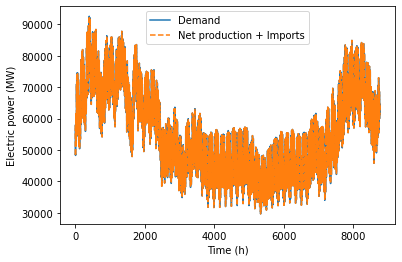

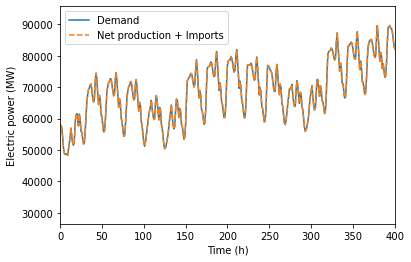

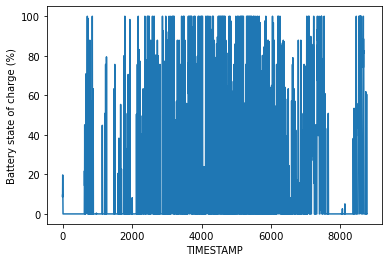

In [14]:
import_elec = outputData['importation_Dvar'].pivot(index='TIMESTAMP',columns='RESOURCES', values='importation_Dvar')['electricity']
prod = outputData['power_Dvar'].pivot(index='TIMESTAMP',columns='TECHNOLOGIES', values='power_Dvar')[['CCG','TAC','OldNuke', 'WindOnShore','Solar','HydroReservoir']].sum(axis=1)
demand_elec = outputData['energy_Pvar'].pivot(index='TIMESTAMP',columns='RESOURCES', values='energy_Pvar')['electricity']
stockIn = outputData['storageIn_Pvar'].pivot(index='TIMESTAMP',columns=['STOCK_TECHNO','RESOURCES'], values='storageIn_Pvar').loc[:, ('Battery', 'electricity')]
stockOut = outputData['storageOut_Pvar'].pivot(index='TIMESTAMP',columns=['STOCK_TECHNO','RESOURCES'], values='storageOut_Pvar').loc[:, ('Battery', 'electricity')]
stockCons = outputData['storageConsumption_Pvar'].pivot(index='TIMESTAMP',columns=['STOCK_TECHNO','RESOURCES'], values='storageConsumption_Pvar').loc[:, ('Battery', 'electricity')]


plt.plot(demand_elec, label='Demand')
plt.plot(prod + import_elec - stockIn + stockOut - stockCons, '--', label='Net production + Imports')
plt.xlabel('Time (h)')
plt.ylabel('Electric power (MW)')
plt.legend(loc=0)

plt.figure()
plt.plot(demand_elec, label='Demand')
plt.plot(prod + import_elec - stockIn + stockOut - stockCons, '--', label='Net production + Imports')
plt.xlim([0,400])
plt.xlabel('Time (h)')
plt.ylabel('Electric power (MW)')
plt.legend(loc=0)

plt.figure()
battery_soh = outputData['stockLevel_Pvar'].pivot(index='TIMESTAMP',columns=['STOCK_TECHNO'], values='stockLevel_Pvar').loc[:, ('Battery')]
battery_soh = 100 * battery_soh / outputData['Cmax_Dvar'].set_index('STOCK_TECHNO').loc['Battery', 'Cmax_Dvar']
battery_soh.plot()
plt.ylabel('Battery state of charge (%)')




In [15]:
costs = pd.DataFrame(data={
    'Conversion tech CAPEX': [outputData['capacityCosts_Pvar']['capacityCosts_Pvar'].sum(axis=0)], 
    'Electricity import cost': [outputData['importCosts_Pvar'].set_index('RESOURCES').loc['electricity','importCosts_Pvar']],
    'Gas import cost': [outputData['importCosts_Pvar'].set_index('RESOURCES').loc['gas','importCosts_Pvar']],
    'Storage cost': [outputData['storageCosts_Pvar'].set_index('STOCK_TECHNO').loc['Battery','storageCosts_Pvar']],

},index=['Single node (FR) with storage']).transpose()
costs.loc['Total', :] =costs.sum(axis=0)
costs

,Single node (FR) with storage
Conversion tech CAPEX,1.687911e+10
Electricity import cost,4.462666e+10
Gas import cost,5.488987e+08
Storage cost,6.131254e+08
Total,6.266779e+10


In [16]:
costs_MWh = costs / demand_elec.sum(axis=0)
costs_MWh

,Single node (FR) with storage
Conversion tech CAPEX,34.305788
Electricity import cost,90.701034
Gas import cost,1.115604
Storage cost,1.246141
Total,127.368567
